# Exploratory Data Analysis of Solar Data

This notebook performs:

1. **Summary statistics & missing-value report**  
2. **Outlier detection & basic cleaning**  
3. **Time-series analysis** of irradiance & temperature  
4. **Cleaning impact** on module readings  
5. **Correlation & relationship analysis**  
6. **Wind and distribution analysis**  
7. **Histograms**  
8. **Bubble chart**
9. **Export cleaned data**

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

df = pd.read_csv("../data/benin-malanville.csv", parse_dates=["Timestamp"])
df.head()

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-08-09 00:01:00,-1.2,-0.2,-1.1,0.0,0.0,26.2,93.4,0.0,0.4,0.1,122.1,0.0,998,0,0.0,26.3,26.2,NaN
1,2021-08-09 00:02:00,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.6,0.0,0.0,0.0,0.0,0.0,998,0,0.0,26.3,26.2,NaN
2,2021-08-09 00:03:00,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.7,0.3,1.1,0.5,124.6,1.5,997,0,0.0,26.4,26.2,NaN
3,2021-08-09 00:04:00,-1.1,-0.1,-1.0,0.0,0.0,26.2,93.3,0.2,0.7,0.4,120.3,1.3,997,0,0.0,26.4,26.3,NaN
4,2021-08-09 00:05:00,-1.0,-0.1,-1.0,0.0,0.0,26.2,93.3,0.1,0.7,0.3,113.2,1.0,997,0,0.0,26.4,26.3,NaN


## Summary Statistics & Missing-Value Report

- `df.describe()` on numeric columns  
- Count nulls (`df.isna().sum()`)  
- List columns with > 5% missing


In [2]:
# Summary stats
display(df.describe())

# Missing-value counts
null = df.isna().sum()
missing = null / len(df) * 100

print("Null counts per column:")
print(null)

print("\nColumns with >5% nulls:")
print(missing[missing > 5])


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
count,525600,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,0.0
mean,2022-02-07 12:00:30.000000512,240.559452,167.187516,115.358961,236.589496,228.883576,28.179683,54.487969,2.121113,2.809195,0.473390,153.435172,8.582407,994.197199,0.000923,0.001905,35.246026,32.471736,NaN
min,2021-08-09 00:01:00,-12.900000,-7.800000,-12.600000,0.000000,0.000000,11.000000,2.100000,0.000000,0.000000,0.000000,0.000000,0.000000,985.000000,0.000000,0.000000,9.000000,8.100000,NaN
25%,2021-11-08 06:00:45,-2.000000,-0.500000,-2.100000,0.000000,0.000000,24.200000,28.800000,1.000000,1.300000,0.400000,59.000000,3.700000,993.000000,0.000000,0.000000,24.200000,23.600000,NaN
50%,2022-02-07 12:00:30,1.800000,-0.100000,1.600000,4.500000,4.300000,28.000000,55.100000,1.900000,2.600000,0.500000,181.000000,8.600000,994.000000,0.000000,0.000000,30.000000,28.900000,NaN
75%,2022-05-09 18:00:15,483.400000,314.200000,216.300000,463.700000,447.900000,32.300000,80.100000,3.100000,4.100000,0.600000,235.100000,12.300000,996.000000,0.000000,0.000000,46.900000,41.500000,NaN
max,2022-08-09 00:00:00,1413.000000,952.300000,759.200000,1342.300000,1342.300000,43.800000,100.000000,19.500000,26.600000,4.200000,360.000000,99.400000,1003.000000,1.000000,2.500000,81.000000,72.500000,NaN
std,NaN,331.131327,261.710501,158.691074,326.894859,316.536515,5.924297,28.073069,1.603466,2.029120,0.273395,102.332842,6.385864,2.474993,0.030363,0.037115,14.807258,12.348743,NaN


Null counts per column:
Timestamp             0
GHI                   0
DNI                   0
DHI                   0
ModA                  0
ModB                  0
Tamb                  0
RH                    0
WS                    0
WSgust                0
WSstdev               0
WD                    0
WDstdev               0
BP                    0
Cleaning              0
Precipitation         0
TModA                 0
TModB                 0
Comments         525600
dtype: int64

Columns with >5% nulls:
Comments    100.0
dtype: float64


## Outlier Detection & Basic Cleaning

- Computation of Z-scores for key columns  
- Outlier flagging for |Z| > 3  
- Imputation of missing values in key columns with median  
- Exporting the cleaned DataFrame


In [3]:
cols = ["GHI","DNI","DHI","ModA","ModB","WS","WSgust"]

# Z-scores & flagging
for c in cols:
    df[f"{c}_z"] = (df[c] - df[c].mean()) / df[c].std(ddof=0)
    df[f"{c}_outlier"] = df[f"{c}_z"].abs() > 3

df["any_outlier"] = df[[f"{c}_outlier" for c in cols]].any(axis=1)

# Median imputation
for c in cols + ["Tamb","RH","WD","BP"]:
    if c in df:
        df[c].fillna(df[c].median(), inplace=True)

# Save cleaned
df.to_csv("../data/benin-malanville_clean.csv", index=False)
print("Cleaned data exported to data/benin-malanville_clean.csv")

df_clean = pd.read_csv("../data/benin-malanville_clean.csv", parse_dates=["Timestamp"])
df_clean.head()


/tmp/ipykernel_1111902/126846932.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[c].fillna(df[c].median(), inplace=True)
/tmp/ipykernel_1111902/126846932.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

Cleaned data exported to data/benin-malanville_clean.csv


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,...,DHI_outlier,ModA_z,ModA_outlier,ModB_z,ModB_outlier,WS_z,WS_outlier,WSgust_z,WSgust_outlier,any_outlier
0,2021-08-09 00:01:00,-1.2,-0.2,-1.1,0.0,0.0,26.2,93.4,0.0,0.4,...,False,-0.723749,False,-0.723088,False,-1.322831,False,-1.187312,False,False
1,2021-08-09 00:02:00,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.6,0.0,0.0,...,False,-0.723749,False,-0.723088,False,-1.322831,False,-1.384442,False,False
2,2021-08-09 00:03:00,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.7,0.3,1.1,...,False,-0.723749,False,-0.723088,False,-1.135736,False,-0.842334,False,False
3,2021-08-09 00:04:00,-1.1,-0.1,-1.0,0.0,0.0,26.2,93.3,0.2,0.7,...,False,-0.723749,False,-0.723088,False,-1.198101,False,-1.039464,False,False
4,2021-08-09 00:05:00,-1.0,-0.1,-1.0,0.0,0.0,26.2,93.3,0.1,0.7,...,False,-0.723749,False,-0.723088,False,-1.260466,False,-1.039464,False,False


## Time-Series Plots

Plot of GHI, DNI, DHI & Tamb vs. Timestamp  

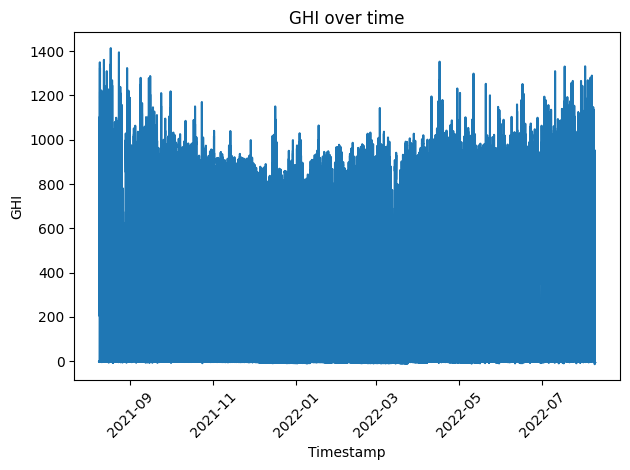

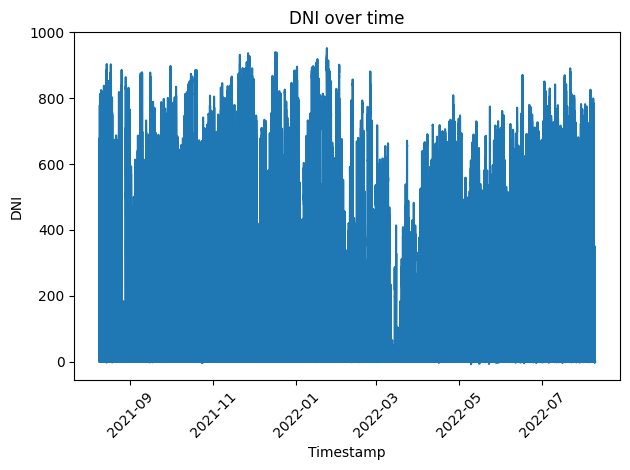

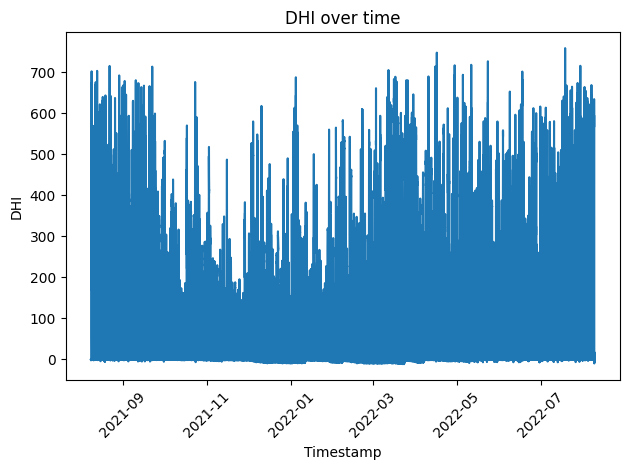

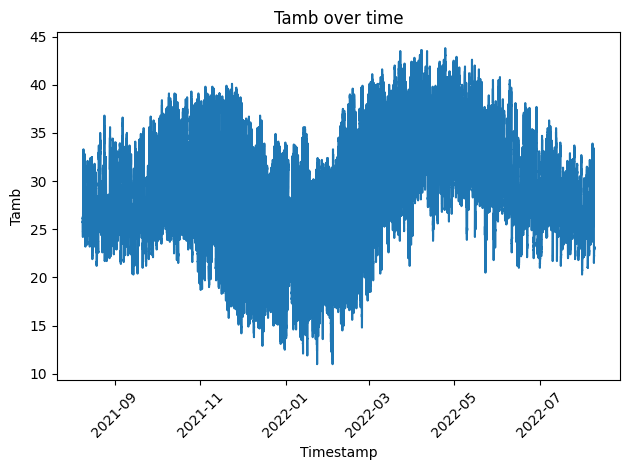

In [4]:
# Line plots
for c in ["GHI","DNI","DHI","Tamb"]:
    plt.figure()
    plt.plot(df["Timestamp"], df_clean[c])
    plt.title(f"{c} over time")
    plt.xlabel("Timestamp")
    plt.ylabel(c)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Anomality check

/tmp/ipykernel_1111902/626694173.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df_clean.set_index("Timestamp").resample("M")["GHI"].mean()


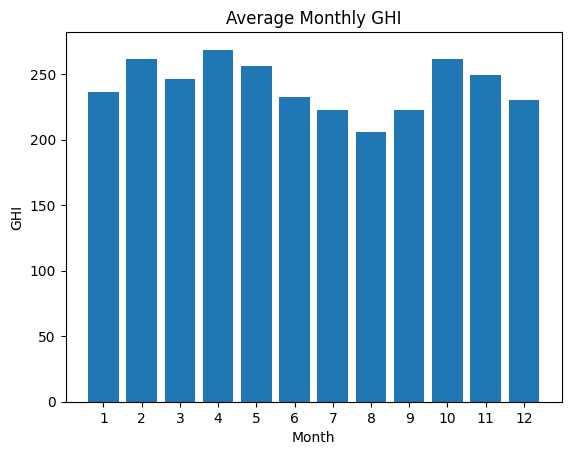

/tmp/ipykernel_1111902/626694173.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df_clean.set_index("Timestamp").resample("M")["DNI"].mean()


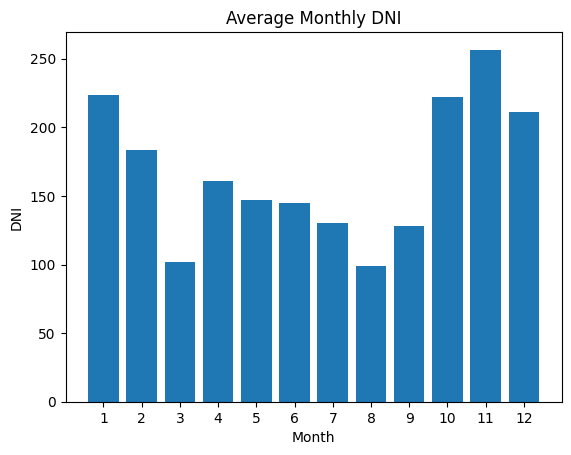

/tmp/ipykernel_1111902/626694173.py:22: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df_clean.set_index("Timestamp").resample("M")["DHI"].mean()


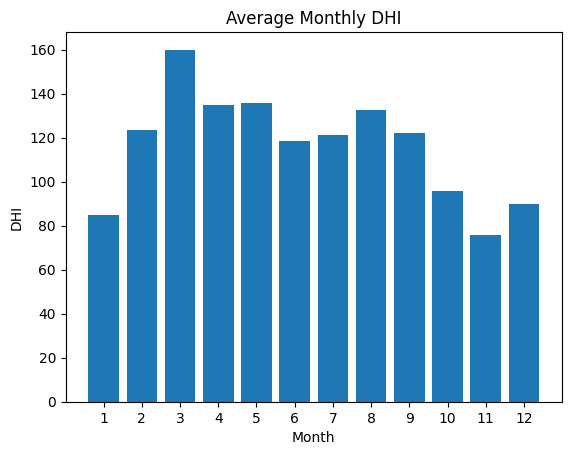

/tmp/ipykernel_1111902/626694173.py:32: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df_clean.set_index("Timestamp").resample("M")["Tamb"].mean()


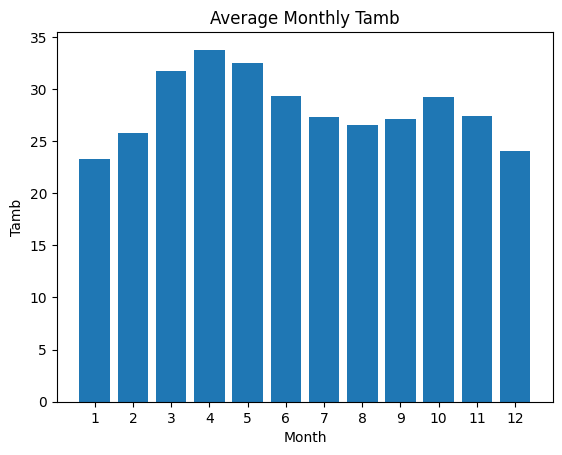

In [5]:

# Monthly average GHI
monthly = df_clean.set_index("Timestamp").resample("M")["GHI"].mean()
plt.figure()
plt.bar(monthly.index.month, monthly.values)
plt.title("Average Monthly GHI")
plt.xlabel("Month")
plt.ylabel("GHI")
plt.xticks(range(1,13))
plt.show()

# Monthly average DNI
monthly = df_clean.set_index("Timestamp").resample("M")["DNI"].mean()
plt.figure()
plt.bar(monthly.index.month, monthly.values)
plt.title("Average Monthly DNI")
plt.xlabel("Month")
plt.ylabel("DNI")
plt.xticks(range(1,13))
plt.show()

# Monthly average DHI
monthly = df_clean.set_index("Timestamp").resample("M")["DHI"].mean()
plt.figure()
plt.bar(monthly.index.month, monthly.values)
plt.title("Average Monthly DHI")
plt.xlabel("Month")
plt.ylabel("DHI")
plt.xticks(range(1,13))
plt.show()

# Monthly average Tamb
monthly = df_clean.set_index("Timestamp").resample("M")["Tamb"].mean()
plt.figure()
plt.bar(monthly.index.month, monthly.values)
plt.title("Average Monthly Tamb")
plt.xlabel("Month")
plt.ylabel("Tamb")
plt.xticks(range(1,13))
plt.show()

## Impact of Cleaning

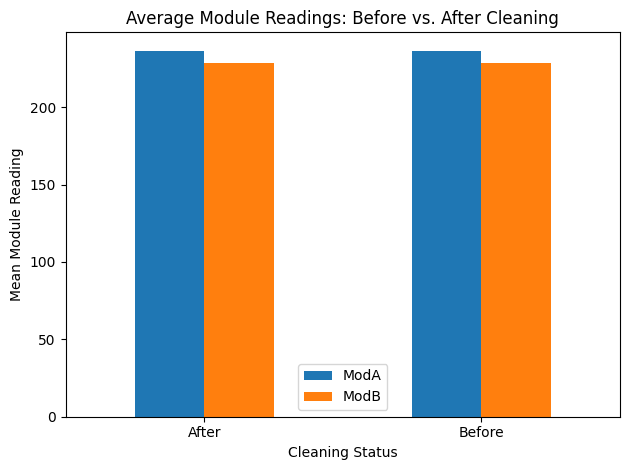

                 ModA        ModB
CleanFlag                        
After      236.589496  228.883576
Before     236.589496  228.883576


In [6]:
df["CleanFlag"]   = "Before"
df_clean["CleanFlag"] = "After"

df_combined_benin = pd.concat([df, df_clean], ignore_index=True)

# 4. Group by flag and compute means
avg = df_combined_benin.groupby("CleanFlag")[["ModA", "ModB"]].mean()

# 5. Plot
ax = avg.plot(kind="bar", rot=0)
ax.set_title("Average Module Readings: Before vs. After Cleaning")
ax.set_xlabel("Cleaning Status")
ax.set_ylabel("Mean Module Reading")
plt.tight_layout()
plt.show()
print(avg)

## Correlation & Scatter Plots

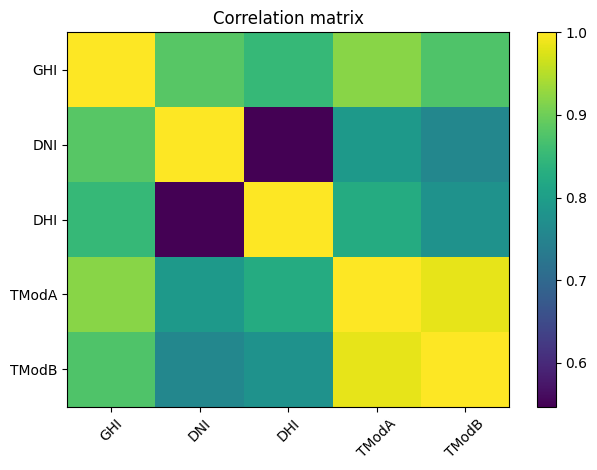

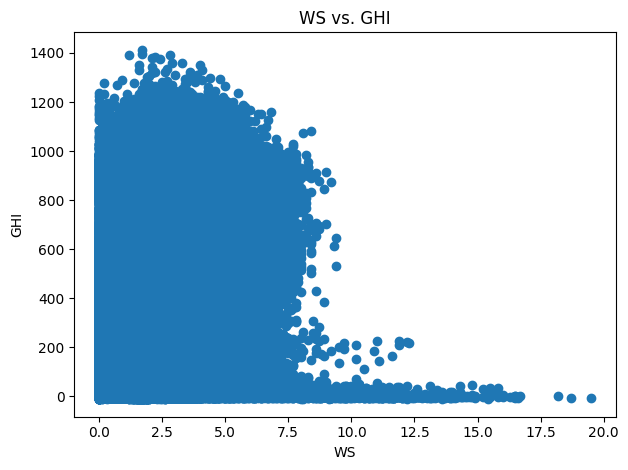

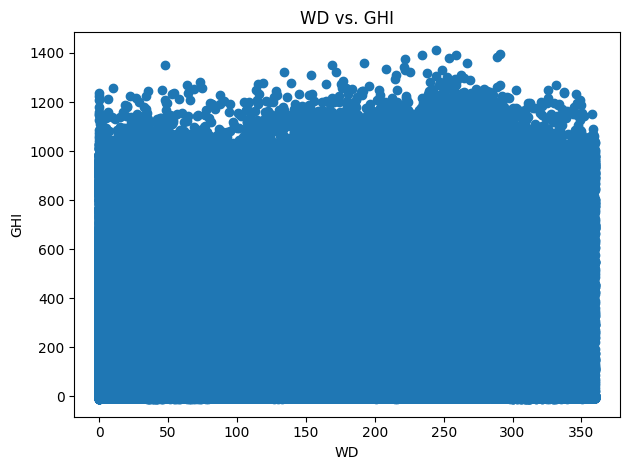

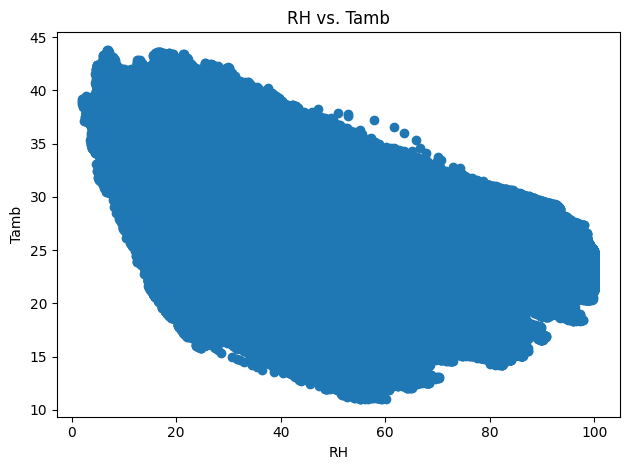

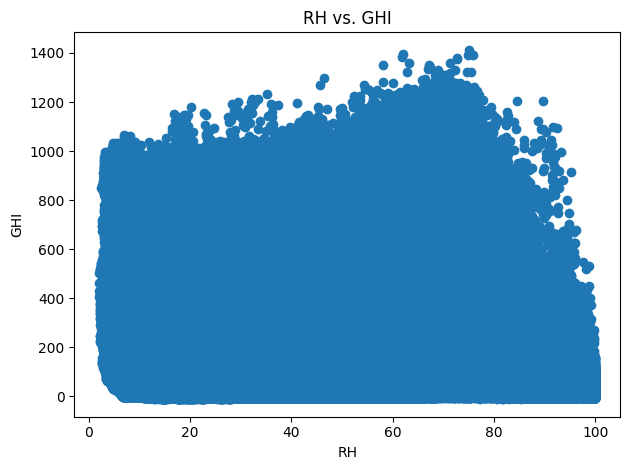

In [7]:
vars_corr = ["GHI","DNI","DHI","TModA","TModB"]
corr = df_clean[vars_corr].corr()

# Heatmap
plt.figure()
plt.imshow(corr, aspect="auto")
plt.colorbar()
plt.xticks(range(len(vars_corr)), vars_corr, rotation=45)
plt.yticks(range(len(vars_corr)), vars_corr)
plt.title("Correlation matrix")
plt.tight_layout()
plt.show()

# Scatter pairs
for x,y in [("WS","GHI"),("WD","GHI"),("RH","Tamb"),("RH","GHI")]:
    if x in df_clean and y in df:
        plt.figure()
        plt.scatter(df[x], df[y])
        plt.title(f"{x} vs. {y}")
        plt.xlabel(x)
        plt.ylabel(y)
        plt.tight_layout()
        plt.show()


## Wind and distribution analysis

/tmp/ipykernel_1111902/1674695785.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wind = df_clean.groupby("WD_bin")["WS"].mean()


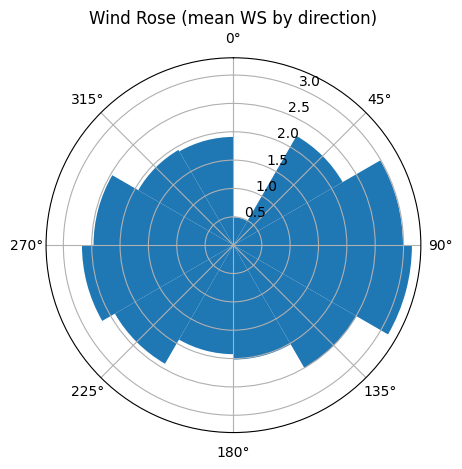

In [8]:
if all(c in df_clean for c in ("WS","WD")):
    bins = np.arange(0,361,30)
    labels = bins[:-1] + 15
    df_clean["WD_bin"] = pd.cut(df["WD"], bins, right=False, labels=labels)
    wind = df_clean.groupby("WD_bin")["WS"].mean()
    angles = np.deg2rad(wind.index.astype(float))
    ax = plt.subplot(projection="polar")
    ax.bar(angles, wind.values, width=np.deg2rad(30), align="center")
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    plt.title("Wind Rose (mean WS by direction)")
    plt.tight_layout()
    plt.show()
else:
    print("WS or WD not in DataFrame.")


## Tempreature analysis

1. Plot of **RH vs. Tamb** with a regression line  
2. Plot of **RH vs. GHI** with a regression line  
3. Computation and display of the slope, intercept, and R² for each model

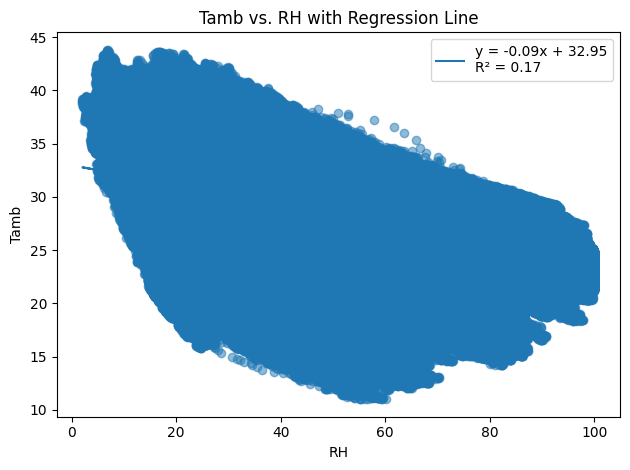

Regression for Tamb ~ RH:
  • Slope     = -0.0875
  • Intercept = 32.9498
  • R²        = 0.1721



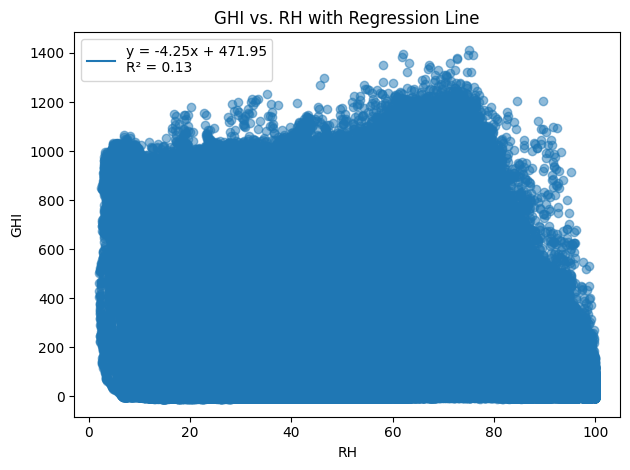

Regression for GHI ~ RH:
  • Slope     = -4.2467
  • Intercept = 471.9513
  • R²        = 0.1296



In [9]:
# Define the two relationships to explore
pairs = [("RH", "Tamb"), ("RH", "GHI")]

for x_col, y_col in pairs:
    # Drop NA
    mask = df_clean[x_col].notna() & df_clean[y_col].notna()
    x = df_clean.loc[mask, x_col]
    y = df_clean.loc[mask, y_col]
    
    # Fit linear regression
    res = linregress(x, y)
    line = res.intercept + res.slope * x
    
    # Plot
    plt.figure()
    plt.scatter(x, y, alpha=0.5)
    plt.plot(x, line, label=(
        f"y = {res.slope:.2f}x + {res.intercept:.2f}\n"
        f"R² = {res.rvalue**2:.2f}"
    ))
    plt.title(f"{y_col} vs. {x_col} with Regression Line")
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Print stats
    print(f"Regression for {y_col} ~ {x_col}:")
    print(f"  • Slope     = {res.slope:.4f}")
    print(f"  • Intercept = {res.intercept:.4f}")
    print(f"  • R²        = {res.rvalue**2:.4f}\n")

## Histograms & Bubble Chart

- Histograms of GHI and WS  
- Bubble: GHI vs. Tamb (bubble size = RH)


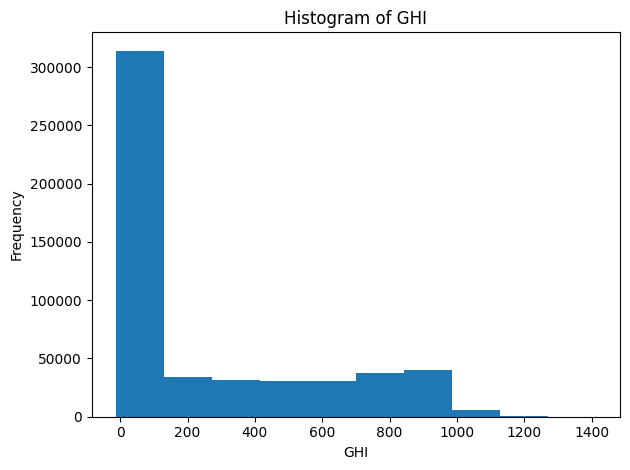

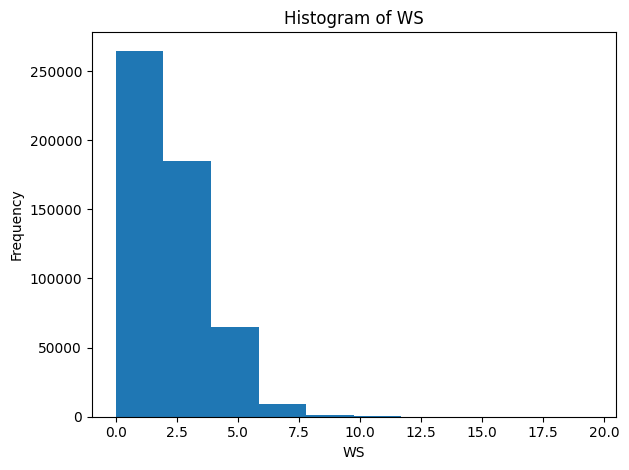

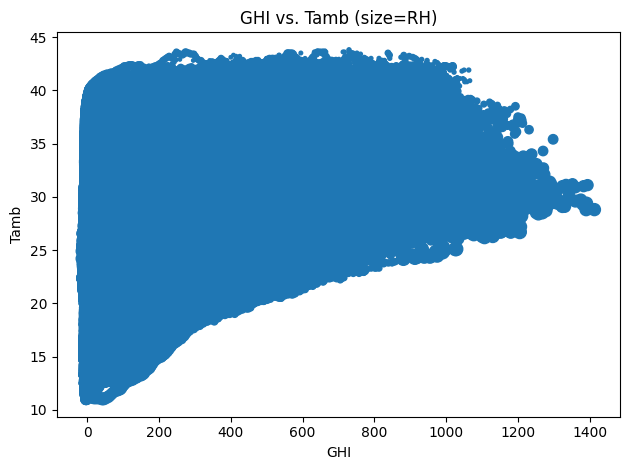

In [10]:
# Histograms
for c in ["GHI","WS"]:
    if c in df_clean:
        plt.figure()
        plt.hist(df[c].dropna())
        plt.title(f"Histogram of {c}")
        plt.xlabel(c)
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

# Bubble chart
if all(c in df_clean for c in ("GHI","Tamb","RH")):
    plt.figure()
    plt.scatter(df_clean["GHI"], df_clean["Tamb"], s=df_clean["RH"])
    plt.title("GHI vs. Tamb (size=RH)")
    plt.xlabel("GHI")
    plt.ylabel("Tamb")
    plt.tight_layout()
    plt.show()
else:
    print("GHI, Tamb, or RH missing.")


## Correlation Coefficients

In [11]:
if "RH" in df_clean:
    if "Tamb" in df_clean:
        print("RH vs. Tamb correlation:", df_clean["RH"].corr(df_clean["Tamb"]))
    if "GHI" in df_clean:
        print("RH vs. GHI correlation:", df_clean["RH"].corr(df_clean["GHI"]))

RH vs. Tamb correlation: -0.4148417749799561
RH vs. GHI correlation: -0.36002868854992726
